# 🚢 Titanic Survival Prediction — Simplified Feature Engineering & ML Pipeline

This notebook helps you understand **Feature Engineering** and **Machine Learning Pipelines** using the Titanic dataset.

We will go from raw data → feature creation → preprocessing → modeling → evaluation — with complete theory and explanations at every step.

## 🧠 What You’ll Learn

1. What feature engineering means and why it’s important.
2. How to handle missing values, categorical variables, and scaling.
3. How to build a **scikit-learn pipeline** for automation.
4. How to evaluate model performance effectively.
5. The full ML workflow — simplified for clarity.

In [ ]:
# Basic imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


# Info of libraries used in the code snippets
# pandas: A powerful data manipulation library for handling structured data.
# seaborn: A statistical data visualization library built on top of Matplotlib.
# matplotlib.pyplot: A plotting library for creating static, animated, and interactive visualizations in Python
# sklearn: A popular machine learning library used for data preprocessing, modeling, and evaluation.
# train_test_split: A function to split the dataset into training and testing sets.
# OneHotEncoder: A preprocessing technique to convert categorical variables into a format that can be provided
# StandardScaler: A preprocessing technique to standardize features by removing the mean and scaling to unit variance.
# SimpleImputer: A preprocessing technique to handle missing values in the dataset.
# ColumnTransformer: A class to apply different preprocessing steps to different columns of the dataset.
# Pipeline: A class to streamline a sequence of data processing steps.
# RandomForestClassifier: An ensemble learning method for classification tasks.
# accuracy_score: A metric to evaluate the accuracy of a classification model.
# classification_report: A function to generate a detailed report of classification metrics.


## 1️⃣ Load & Explore Data

We use the built-in Titanic dataset from **Seaborn**. Each row represents a passenger, with information like class, gender, age, and survival status.

**Target Column:** `survived` → 1 means survived, 0 means not survived.

In [35]:
df = sns.load_dataset('titanic')
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]
print(f"Shape: {df.shape}")
df.head()

Shape: (891, 8)


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### 🔍 Data Overview
- **pclass**: Ticket class (1st, 2nd, 3rd)
- **sex**: Gender of the passenger
- **age**: Age in years
- **sibsp**: # of siblings/spouses aboard
- **parch**: # of parents/children aboard
- **fare**: Ticket fare
- **embarked**: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

Let’s check for missing values and understand survival patterns.

In [36]:
df.info()
print("\nMissing values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   sex       891 non-null    object 
 3   age       714 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB

Missing values:
 survived      0
pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
dtype: int64


### 📊 Visual Exploration

We can visualize survival rates by different features to understand their influence.

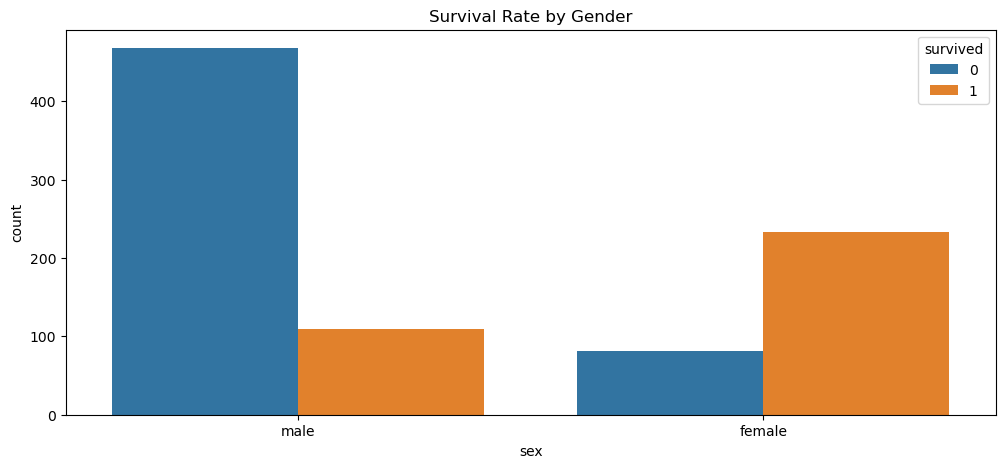

C:\Users\Shake\AppData\Local\Temp\ipykernel_31556\2642780551.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='pclass', y='survived', data=df, ci=None)


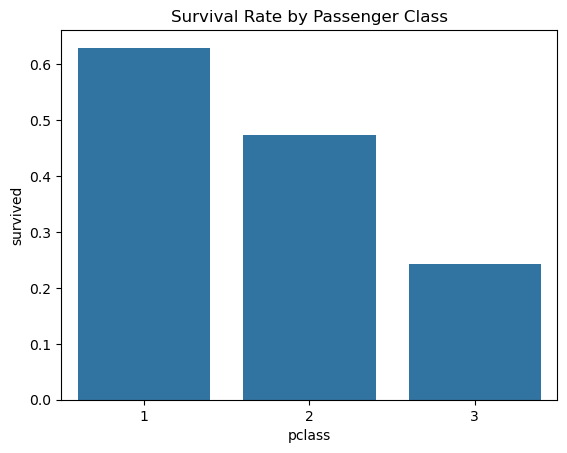

In [37]:
plt.figure(figsize=(12,5))
sns.countplot(x='sex', hue='survived', data=df)
plt.title('Survival Rate by Gender')
plt.show()

sns.barplot(x='pclass', y='survived', data=df, ci=None)
plt.title('Survival Rate by Passenger Class')
plt.show()

💡 **Insight:**
- Females had much higher survival rates.
- 1st class passengers survived more often than 3rd class.

This means both **`sex`** and **`pclass`** are important predictors!

## 2️⃣ Feature Engineering — Creating New Information

Feature engineering helps create **more informative inputs** from existing data.

We’ll add:
- **`family_size`** = `sibsp` + `parch` + 1 → total people traveling together
- **`is_alone`** = 1 if family size = 1, else 0
- **`age_pclass`** = interaction term combining age and class

In [38]:
df['family_size'] = df['sibsp'] + df['parch'] + 1
df['is_alone'] = (df['family_size'] == 1).astype(int)
df['age_pclass'] = df['age'] * df['pclass']
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,family_size,is_alone,age_pclass
0,0,3,male,22.0,1,0,7.2500,S,2,0,66.0
1,1,1,female,38.0,1,0,71.2833,C,2,0,38.0
2,1,3,female,26.0,0,0,7.9250,S,1,1,78.0
3,1,1,female,35.0,1,0,53.1000,S,2,0,35.0
4,0,3,male,35.0,0,0,8.0500,S,1,1,105.0


✅ **Why do this?**
- Passengers with family might help each other → higher survival.
- Combining age × class may reveal richer relationships (younger + 1st class = high survival).

## 3️⃣ Train-Test Split

We separate the dataset into **training** (for model learning) and **testing** (for final evaluation).

In [39]:
X = df.drop('survived', axis=1)
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape

((712, 10), (179, 10))

## 4️⃣ Preprocessing Steps Explained

### 🧩 What Preprocessing Does
- **Imputation:** Replace missing values (with median or most frequent).
- **Encoding:** Convert categorical data (`sex`, `embarked`) into numbers.
- **Scaling:** Normalize numeric values so all features have equal influence.

We’ll handle all of these using scikit-learn’s **`ColumnTransformer`** and **`Pipeline`**.

In [40]:
numeric_cols = ['age', 'fare', 'sibsp', 'parch', 'family_size', 'age_pclass']
categorical_cols = ['sex', 'embarked', 'pclass', 'is_alone']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

## 5️⃣ Full Pipeline — From Raw Data to Prediction

A **Pipeline** chains preprocessing and model training together. This ensures:
- Clean code
- Less data leakage
- Easier deployment

In [41]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.799
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       110
           1       0.76      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.80      0.80      0.80       179



## 6️⃣ Understanding the Flow — Step-by-Step

| Step | Operation | Example | Why It Matters |
|------|------------|----------|----------------|
| 1 | Imputation | Fill missing `age` with median | Prevents errors from NaN values |
| 2 | Encoding | Convert `sex` → 0/1 | Makes categories usable for ML |
| 3 | Scaling | Normalize numeric columns | Improves model stability |
| 4 | Training | Fit RandomForest on clean data | Learns survival patterns |
| 5 | Prediction | Apply same steps to test data | Ensures consistency |

⚙️ Everything (fit → transform → predict) is handled **automatically** by the pipeline!

## 7️⃣ Final Summary — Theory Recap

### ✅ **What is Feature Engineering?**
Creating meaningful features from raw data to improve model performance.

### ✅ **Why Use Pipelines?**
- Keeps all transformations consistent
- Avoids data leakage
- Reproducible and production-friendly

### ✅ **Random Forest Advantages:**
- Handles non-linear relationships well
- Robust to missing and categorical data (after preprocessing)
- Gives feature importance insights

### ⚠️ **Limitations:**
- No hyperparameter tuning yet
- Random Forest is a black-box model
- Still basic; can be extended with GridSearchCV

---
### 🏁 End of Notebook — Key Takeaways
- Feature Engineering improves learning quality.
- Pipelines automate preprocessing.
- Always validate using a test set.

**Next Steps:**
- Try adding feature selection.
- Compare Random Forest with Logistic Regression.
- Tune hyperparameters for better accuracy.

🚀 You now understand a complete ML pipeline — theory + practice!